In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/20212/class/nlp/ner-vietnamese/src/CRF

/content/drive/MyDrive/20212/class/nlp/ner-vietnamese/src/CRF


In [3]:
# !pip install swifter
# !pip install sklearn-crfsuite

In [30]:
import utils

DATA_PATH = "/content/drive/MyDrive/20212/class/nlp/ner-vietnamese/data-new/dataset"
train =utils.pre_process('train',DATA_PATH)
dev = utils.pre_process('dev',DATA_PATH)
test = utils.pre_process('test',DATA_PATH)

Pandas Apply:   0%|          | 0/626542 [00:00<?, ?it/s]

load train


Pandas Apply:   0%|          | 0/121897 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/255120 [00:00<?, ?it/s]

In [5]:
dev['sentence_id'] = dev.apply(lambda row: row.sentence_id + 32000, axis=1)
test['sentence_id'] = test.apply(lambda row: row.sentence_id + 40000, axis=1)

In [6]:
import pandas as pd
train = pd.concat([train,dev,test])

In [32]:
train_report = train.copy()

In [33]:
train_report

,sentence_id,words,labels
0,0,Trường,O
1,0,hợp,O
2,0,nào,O
3,0,chấm,O
4,0,dứt,O
...,...,...,...
615540,30084,trì,O
615541,30084,trệ,O
615542,30084,việc,O
615543,30084,thoái,O


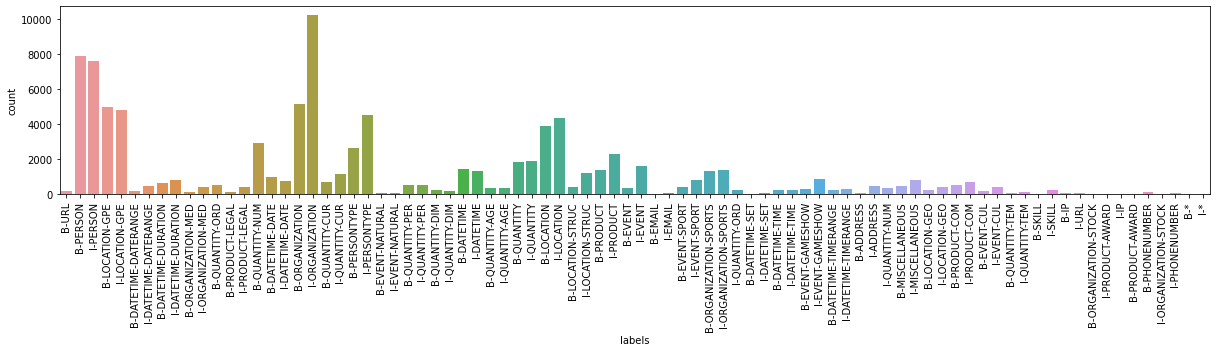

In [34]:
import seaborn as sns

plt.figure(figsize=(17, 5))

data_ner_non_null = train_report.drop(train_report[train_report['labels'] == 'O'].index)

ax = sns.countplot('labels', data=data_ner_non_null)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [35]:
data_ner_non_null

,sentence_id,words,labels
13,1,Chinhphu.vn,B-URL
15,1,Nguyễn,B-PERSON
16,1,Tú,I-PERSON
17,1,Ngân,I-PERSON
18,1,An,B-LOCATION-GPE
...,...,...,...
615446,30080,Thủ,B-PERSONTYPE
615447,30080,tướng,I-PERSONTYPE
615448,30080,Chính,I-PERSONTYPE
615449,30080,phủ,I-PERSONTYPE


In [38]:
import pandas as pd 
train1 = pd.DataFrame()
train1['remove'] = data_ner_non_null.apply(lambda row: row.labels[2:], axis=1)

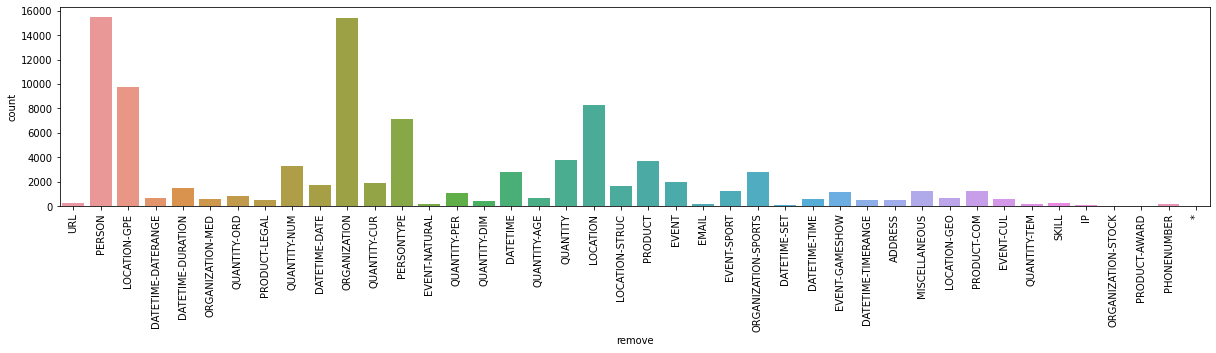

In [41]:
plt.figure(figsize=(17, 5))

ax = sns.countplot('remove', data=train1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [27]:
train_report

,sentence_id,words,labels
0,0,Trường,O
1,0,hợp,O
2,0,nào,O
3,0,chấm,O
4,0,dứt,O
...,...,...,...
250334,50329,chi,O
250335,50329,tiêu,O
250336,50329,hợp,O
250337,50329,lý,O


In [7]:
train_data = train.copy()

In [8]:
from itertools import chain

import nltk
import sklearn
import scipy.stats

import sklearn_crfsuite
from sklearn_crfsuite import scorers,CRF
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn_crfsuite import metrics

In [9]:
# train1[] = train_data.groupby('sentence_id')
import pandas as pd 
train1 = pd.DataFrame()
train1['pair'] = train_data.apply(lambda row: (row.words,row.labels), axis=1)
train1['id_sent'] = train_data['sentence_id']

In [10]:
train2 = pd.DataFrame()
train2['data'] = train1.groupby('id_sent')['pair'].apply(list)

In [11]:
train3 = train2['data'].tolist()

In [12]:
len(train3)

32950

In [13]:
import utils
X = [utils.sent2features(s) for s in train3]
y = [utils.sent2labels(s) for s in train3]

In [14]:
crf = CRF(algorithm='lbfgs',
          c1=0.1,
          c2=1,
          max_iterations=100,
          all_possible_transitions=False)

In [15]:
train_index = int(len(y)*0.8)
train_index

26360

In [16]:
X_train = X[0:train_index]
X_test = X[train_index+1:]

y_train = y[0:train_index]
y_test = y[train_index+1:]

In [ ]:
crf.fit(X_train, y_train)

In [18]:
labels= utils.get_list_tag()

In [19]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,
                      average='weighted', labels=labels)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


0.47695916376790537

In [20]:
flat_true =[]
flat_pred =[]
for sent in y_test:
  for x in sent:
    flat_true.append(x)

for sent in y_pred:
  for x in sent:
    flat_pred.append(x)

In [21]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)

labels.sort()
import sklearn
print(sklearn.metrics.classification_report(
    flat_true, flat_pred, labels=labels, digits=3
))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

                       precision    recall  f1-score   support

            B-ADDRESS      0.000     0.000     0.000         2
           B-DATETIME      0.846     0.652     0.736       908
      B-DATETIME-DATE      0.719     0.379     0.496       169
 B-DATETIME-DATERANGE      0.077     0.017     0.028        59
  B-DATETIME-DURATION      0.750     0.738     0.744       256
       B-DATETIME-SET      0.000     0.000     0.000         1
      B-DATETIME-TIME      0.444     0.174     0.250        23
 B-DATETIME-TIMERANGE      0.167     0.018     0.032        56
              B-EMAIL      0.500     1.000     0.667         1
              B-EVENT      0.086     0.086     0.086        35
          B-EVENT-CUL      0.500     0.023     0.043        44
     B-EVENT-GAMESHOW      0.353     0.188     0.245        32
      B-EVENT-NATURAL      0.000     0.000     0.000         0
        B-EVENT-SPORT      0.378     0.400     0.389        35
                 B-IP      0.000     0.000     0.000  

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
flat_true_coff = []
flat_preds_coff = []

for sent in y_test:
  for x in sent:
    if '-' in x:
        x = x.split('-')[1]
    flat_true_coff.append(x) 

for sent in y_pred:
  for x in sent:
    if '-' in x:
        x = x.split('-')[1]
    flat_preds_coff.append(x) 

print(len(flat_preds_coff))
print(len(flat_true_coff))

label_rm_begin = []
for x in labels:
    if '-' in x:
        x = x.split('-')[1]
    label_rm_begin.append(x)

label_rm_begin = list(set(label_rm_begin))

label_rm_begin.sort()



216297
216297


In [23]:
x = set(label_rm_begin)

In [24]:
label_rm_begin

['ADDRESS',
 'DATETIME',
 'EMAIL',
 'EVENT',
 'IP',
 'LOCATION',
 'MISCELLANEOUS',
 'ORGANIZATION',
 'PERSON',
 'PERSONTYPE',
 'PHONENUMBER',
 'PRODUCT',
 'QUANTITY',
 'SKILL',
 'URL']

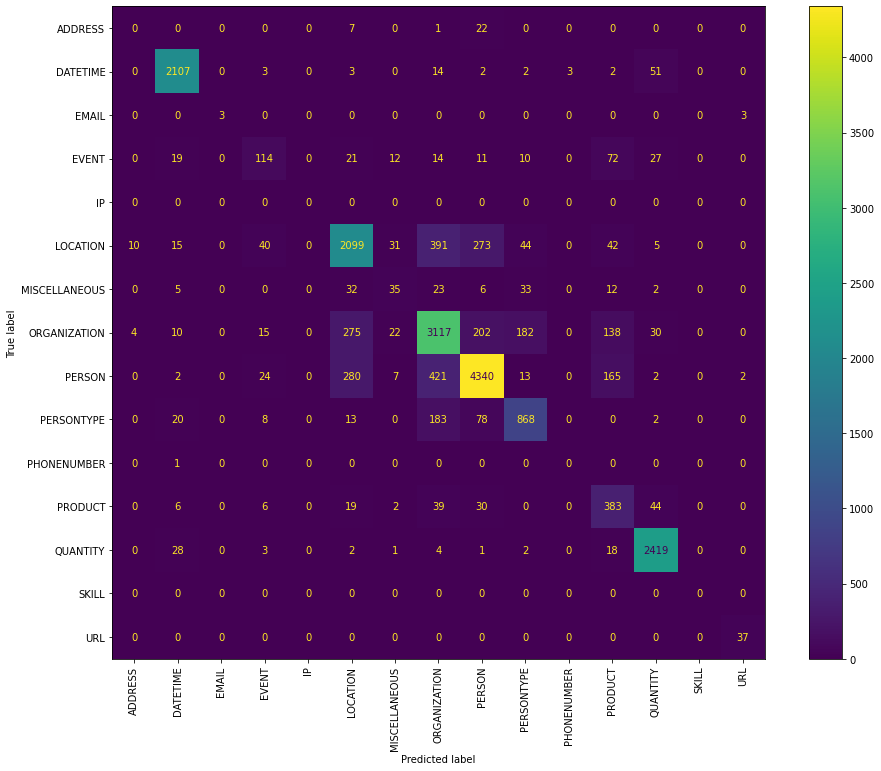

In [25]:
%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(flat_preds_coff, flat_true_coff, labels=label_rm_begin)
fig, ax = plt.subplots(figsize=(16, 12))
# sns.heatmap(cm, annot=True, xticklabels=label_rm_begin, yticklabels=label_rm_begin)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_rm_begin)

disp.plot(ax=ax)
plt.xticks(rotation = 90)
plt.show()  
